In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import yfinance as yf

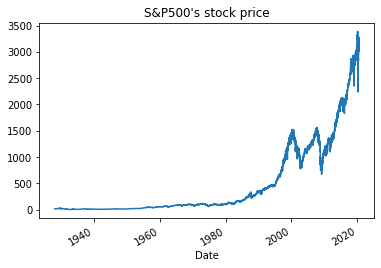

In [3]:
# data for S&P500
ticker = yf.Ticker('^GSPC')

SP500_df = ticker.history(period="max", interval='1d')

SP500_df['Close'].plot(title="S&P500's stock price")

In [4]:
SP500_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,0,0,0
1928-01-03,17.76,17.76,17.76,17.76,0,0,0
1928-01-04,17.72,17.72,17.72,17.72,0,0,0
1928-01-05,17.55,17.55,17.55,17.55,0,0,0
1928-01-06,17.66,17.66,17.66,17.66,0,0,0


In [5]:
SP500_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-07-17,3224.21,3233.52,3205.65,3224.73,3993830000,0,0
2020-07-20,3224.29,3258.61,3215.16,3251.84,3971200000,0,0
2020-07-21,3268.52,3277.29,3247.77,3257.30,4547960000,0,0
2020-07-22,3254.86,3279.32,3253.10,3276.02,4255190000,0,0
2020-07-23,3271.64,3279.99,3254.27,3257.53,1487123627,0,0


In [6]:
SP500_df.shape

(23250, 7)

In [7]:
SP500_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23250 entries, 1927-12-30 to 2020-07-23
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          23250 non-null  float64
 1   High          23250 non-null  float64
 2   Low           23250 non-null  float64
 3   Close         23250 non-null  float64
 4   Volume        23250 non-null  int64  
 5   Dividends     23250 non-null  int64  
 6   Stock Splits  23250 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 1.4 MB


In [8]:
SP500_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,23250.000000,23250.000000,23250.000000,23250.000000,2.325000e+04,23250.0,23250.0
mean,477.740040,480.549388,474.746477,477.838240,7.583226e+08,0.0,0.0
std,708.964186,712.755332,704.815927,709.063834,1.474288e+09,0.0,0.0
min,4.400000,4.400000,4.400000,4.400000,0.000000e+00,0.0,0.0
25%,23.790000,23.790000,23.790000,23.790000,1.260000e+06,0.0,0.0
50%,99.320000,100.085000,98.525000,99.320000,1.705500e+07,0.0,0.0
75%,807.312500,815.942500,800.275000,808.230000,5.142050e+08,0.0,0.0
max,3380.450000,3393.520000,3378.830000,3386.150000,1.145623e+10,0.0,0.0


In [9]:
SP500_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
SP500_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.999971,0.999958,0.999930,0.819320
High,0.999971,1.000000,0.999941,0.999963,0.820291
Low,0.999958,0.999941,1.000000,0.999965,0.817964
Close,0.999930,0.999963,0.999965,1.000000,0.819114
Volume,0.819320,0.820291,0.817964,0.819114,1.000000


In [10]:
# train-test splitting
train_data = SP500_df['Open'].values[:20000]
test_data = SP500_df['Open'].values[20000:]

In [11]:
# data preprocessing
train = train_data.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train)

# prepare training dataset for 60 timesteps
x_train = []
y_train = []

for i in range(train.shape[0]-60):
    x_train.append(train[i:i+60, 0])
    y_train.append(train[i+60, 0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], 1))

In [12]:
x_train.shape

(19940, 60, 1)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import metrics

In [14]:
model = Sequential()

# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=70, return_sequences=True))
model.add(Dropout(rate=0.1))

model.add(LSTM(units=70, return_sequences=True))
model.add(Dropout(rate=0.1))

model.add(LSTM(units=70, return_sequences=False))
model.add(Dropout(rate=0.1))

model.add(Dense(units=1))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[metrics.mae])

In [15]:
model.fit(x_train, y_train, batch_size=128, epochs=3, verbose=1)

Train on 19940 samples
Epoch 1/3
19940/19940 [==============================] - 35s 2ms/sample - loss: 0.0037 - mean_absolute_error: 0.0298
Epoch 2/3
19940/19940 [==============================] - 36s 2ms/sample - loss: 0.0014 - mean_absolute_error: 0.0206
Epoch 3/3
19940/19940 [==============================] - 41s 2ms/sample - loss: 0.0011 - mean_absolute_error: 0.0183


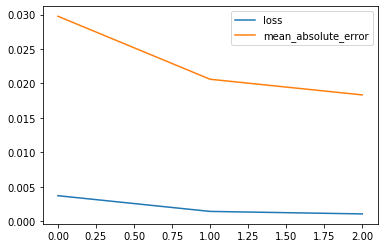

In [16]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [17]:
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# def create_model(l=4, n=50, r=0.1, opt='rmsprop'):
#     model = Sequential()
#     for j in range(l):
#         model.add(LSTM(units=n, return_sequences=True))
#         model.add(Dropout(rate=r))
#     model.add(Dense(units=1))
#     model.compile(optimizer=opt, loss='mean_squared_error', metrics=[metrics.mae])
#     return model
    
# model = KerasRegressor(build_fn=create_model, epochs=6, batch_size=32)

# from sklearn.model_selection import RandomizedSearchCV

# parameters = dict(n=[40, 50, 60, 70, 80],
#                   r=[0.1, 0.3, 0.5],
#                   l=[3, 4, 5, 6],
#                   batch_size=[32, 64, 128],
#                   opt=['sgd', 'rmsprop', 'adam'])

# tuner = RandomizedSearchCV(model, param_distributions=parameters, cv=3, n_iter=10, n_jobs=-1, verbose=1)

# tuned_results = tuner.fit(x_train, y_train)

In [18]:
# # summarize results
# print("Best: %f using %s" % (tuned_results.best_score_, tuned_results.best_params_))

# means = tuned_results.cv_results_['mean_test_score']
# stds = tuned_results.cv_results_['std_test_score']
# params = tuned_results.cv_results_['params']
# # for mean, stdev, param in zip(means, stds, params):
# #     print("%f (%f) with: %r" % (mean, stdev, param))

In [19]:
total_data = SP500_df['Open'].values.reshape(-1, 1)

total_data = scaler.transform(total_data)

x_test = []
for i in range(len(test_data)):
    x_test.append(total_data[i-len(test_data)-60:i-len(test_data), 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_test.shape[1], 1))

In [20]:
y_test = test_data.reshape(-1, 1)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

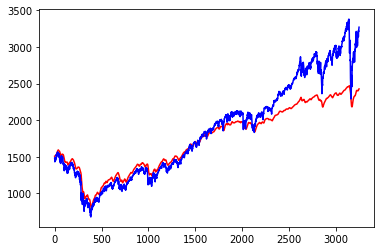

In [21]:
plt.plot(predictions, color='red')
plt.plot(y_test, color='blue')
plt.show()

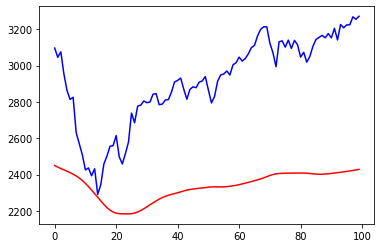

In [22]:
plt.plot(predictions[-100:], color='red')
plt.plot(y_test[-100:], color='blue')
plt.show()

In [23]:
model.evaluate(x_test, y_test)

3250/3250 [==============================] - ETA: 0s - loss: 3858142.5179 - mean_absolute_error: 1850.45 - 3s 991us/sample - loss: 3892568.0689 - mean_absolute_error: 1857.7809


[3892568.068923077, 1857.7809]

In [24]:
from sklearn.metrics import mean_squared_error
RMSE = round(np.sqrt(mean_squared_error(y_test, predictions)), 2)
print(RMSE)

276.59


In [29]:
# Save model
import joblib
from tensorflow.keras.models import save_model

model.save('Base_model')
print("Model dumped!")

INFO:tensorflow:Assets written to: Base_model\assets
Model dumped!


In [33]:
save_model('Base_model')

AttributeError: 'str' object has no attribute 'built'